# Face Recognition Re Implementation

### Imports
See [`requirements.txt`](./requirements.txt)

In [1]:
import numpy as np
import scipy as sp
from enum import Enum
import matplotlib.pyplot as plt
import doctest # To test the code with the examples in the docstring of the functions
import os
from PIL import Image
import tensorflow as tf
# To avoid the warning of tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
from tqdm import tqdm

2024-04-13 19:48:50.392925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 19:48:51.169237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# II.B. Eigenface Method

In [2]:
def averageFace(Q : np.ndarray) -> np.ndarray :
    """
    Compute the average face of a set of images (sketches or photos)

    Parameters
    ----------
    Q : np.array
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.

    Returns
    -------
    np.array
        A 2D numpy array of shape (n, 1) containing the average face.
    """
    return np.mean(Q, axis=1).reshape(-1,1)

def eigenfaces(Q : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray] :
    """
    Implementation of the eigenfaces algorithm

    Parameters
    ----------
    Q : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenfaces
    np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenvectors
    np.ndarray
        A 2D numpy array of shape (m, m) containing the matrix of eigenvalues after transformations

    >>> eigenfaces(np.array([[2,0],[0,5]]))[0].shape
    (2, 2)

    """
    # Compute the mean of the columns of Q (mean image)
    mp = averageFace(Q)
    # Subtract the mean from each column of Q
    Ap = Q - mp
    # Compute eigenvector matrix and eigenvalues of Atp*Ap
    eigvals, Vp = np.linalg.eig(Ap.T @ Ap)

    # Compute the orthormal eigenvector matrix of the covariance matrix
    eigPower = np.linalg.pinv(sp.linalg.sqrtm(np.diag(eigvals)))
    Up = Ap @ Vp @ eigPower

    return Up, Vp, eigPower

def featuresEigenfaces(Up : np.ndarray, P : np.ndarray) -> np.ndarray :
    """
    Implementation of the featuresEigenfaces algorithm.

    Parameters
    ----------
    Up : np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenfaces.
    P : np.ndarray
        A 2D numpy array of shape (n, k) where n is the number of pixels in each image and k is the number of images.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (m, k) containing the features of the images.
    """
    return Up.T @ P

In [3]:
# use doctest to test the functions
doctest.testmod(verbose=True)

Trying:
    eigenfaces(np.array([[2,0],[0,5]]))[0].shape
Expecting:
    (2, 2)
ok
3 items had no tests:
    __main__
    __main__.averageFace
    __main__.featuresEigenfaces
1 items passed all tests:
   1 tests in __main__.eigenfaces
1 tests in 4 items.
1 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=1)

In [4]:
def getData(path : str) -> tuple[np.ndarray, list[str]]:
    """
    Reads the images data in the given path and returns it as a numpy array (each column represent an image)

    Parameters
    ----------
    path : str
        The path to the directory containing the images data.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    list
        A list containing the filenames of the images.
    """
    # Initialize the array of images
    dir = os.listdir(path)
    dir.sort()
    img = Image.open(path + dir[0])
    # if image has 3 channels, convert it to grayscale
    img = img.convert('L') if len(np.array(img).shape) == 3 else img

    nbPixels = np.array(img).flatten().shape

    images = np.empty((nbPixels[0],len(dir)))

    # Shuffle the images with a given seed (guarantee reproducibility of the results and the
    # same order for photos/sketches)
    rd = np.random.RandomState(42)
    rd.shuffle(dir)
    filenames: list[str] = []
    for i,filename in enumerate(dir):
        img = Image.open(path + filename)
        # if image has 3 channels, convert it to grayscale
        img = img.convert('L') if len(np.array(img).shape) == 3 else img
        images[:,i] = np.array(img).flatten().transpose()

        filenames.append(filename)

    return images, filenames

def plotResults(inputRGB : np.ndarray,inputGrayscale : np.ndarray, pseudoSketch : np.ndarray, imageName : str, sketchPath : str):
    """
    Create a plot of three subplots to show the results

    Parameters
    ----------
    inputRGB : np.ndarray
        A 3D numpy array of shape (n, m, 3) containing the input RGB image.
    inputGrayscale : np.ndarray
        A 2D numpy array of shape (n*m) containing the input grayscale image.
    pseudoSketch : np.ndarray
        A 2D numpy array of shape (n*m) containing the pseudo-sketch image.

    Returns
    -------
    None
    """
    size = inputRGB.shape[0:2]

    fig, ax = plt.subplots(2,2)
    ax[0,0].imshow(inputRGB)
    ax[0,0].set_title('Original Image')
    ax[0,0].axis('off')

    ax[0,1].imshow(inputGrayscale.reshape(size),cmap='gray')
    ax[0,1].set_title('Grayscale Image')
    ax[0,1].axis('off')

    ax[1,0].imshow(pseudoSketch.reshape(size),cmap='gray')
    ax[1,0].set_title('Pseudo-sketch Image')
    ax[1,0].axis('off')

    ax[1,1].imshow(np.array(Image.open(sketchPath + imageName)),cmap='gray')
    ax[1,1].set_title('Real sketch Image')
    ax[1,1].axis('off')

    plt.show()

# III.A. Photo-to-Sketch Transformation

> In this section, we reimplement the III.A part of the article, following the 6 steps described

In [5]:
PHOTO_PATH = "./data/photos/"
SKETCH_PATH = "./data/sketches/"

class Dataset:
    def __init__(self, photo_path: str, sketch_path: str, n_splits: int = 5) -> None:
        """
        Creates cross-validation dataset with photos and sketches

        Parameters
        ----------
        photoPath: str
            Path to the photos directory
        sketchPath: str
            Path to the sketches directory
        n_splits: int
            Number of splits testing will be 1/n_splits of the data (default: 5) (80/20)
        """
        self.photo_set, self.photo_names = getData(photo_path)
        self.sketch_set, self.sketch_names = getData(sketch_path)
        trains, tests = Dataset.train_test_split(self.photo_set.shape[1], n_splits)

        self.train_id, self.test_id = trains, tests

        # List of training and testing sets for photos and sketches with cross validation
        self.photo_trains = [self.photo_set[:, train] for train in trains]
        self.photo_tests = [self.photo_set[:, test] for test in tests]
        self.sketch_trains = [self.sketch_set[:, train] for train in trains]
        self.sketch_tests = [self.sketch_set[:, test] for test in tests]

        # Default training and testing sets (for no cross-validation)
        self.photo_train_default = self.photo_trains[-1]
        self.photo_test_default = self.photo_tests[-1]
        self.sketch_train_default = self.sketch_trains[-1]
        self.sketch_test_default = self.sketch_tests[-1]


    @staticmethod
    def train_test_split(n_data: int, n_splits: int = 5
                     ) -> tuple[list[np.ndarray], list[np.ndarray]]:
        """
        Generate training and testing sets for cross-validation

        Parameters
        ----------
        n_data: int
            Size of the dataset
        n_splits: int
            Number of splits testing will be 1/n_splits of the data (default: 5) (80/20)

        Returns
        -------
        list
            List of training sets
        list
            List of testing sets
        """
        splits = np.array_split(np.arange(n_data), n_splits)
        splits_train = []
        splits_test = []
        for k in range(n_splits):
            splits_train.append(np.concatenate([splits[i] for i in range(n_splits) if i != k]))
            splits_test.append(splits[k])
        return splits_train, splits_test

    def get_default_sets(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        return (
            self.photo_train_default,
            self.photo_test_default,
            self.sketch_train_default,
            self.sketch_test_default
        )

def pseudoSketchTransfo(photo_train : np.ndarray, sketch_train : np.ndarray, input_images : np.ndarray) -> np.ndarray:
    """
    Implementation of the pseudoSketchTransfo algorithm.

    Parameters
    ----------
    photo_train : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    sketch_train : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    input_images : np.ndarray
        A 2D numpy array of shape (n, d) containing the input images, where d is the number of images.

    Returns
    -------
    np.array
        A 2D numpy array of shape (n, d) containing the pseudo-sketch images for each input image.
    """

    # Step 1
    mp = averageFace(photo_train)
    ms = averageFace(sketch_train)

    # Step 2
    Ap = photo_train - mp
    Up, Vp, eigPower = eigenfaces(Ap)

    # Step 3 adapted to multiple input images
    Pk = input_images - mp

    # Step 4 adapted to multiple input images
    bp = featuresEigenfaces(Up, Pk)

    # Step 5 : Reconstruction of the pseudo-sketch
    As = sketch_train - ms
    Sr = As @ Vp @ eigPower @ bp

    # Step 6
    Tr = Sr + ms

    # Get the real part of the image and plot the results
    return Tr.real

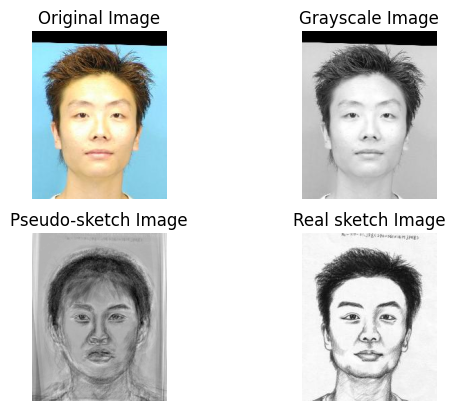

In [6]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 5)

pseudo_sk = pseudoSketchTransfo(
    dataset.photo_train_default,
    dataset.sketch_train_default,
    dataset.photo_test_default[0])

image_name = dataset.photo_names[dataset.test_id[-1][0]]

plotResults(
    np.array(Image.open(PHOTO_PATH + image_name)),
    dataset.photo_test_default[:,0],
    pseudo_sk[:,0],
    image_name,
    SKETCH_PATH)


# III.B. Sketch Recognition

### Main function helpers

In [106]:
class Results:
    def __init__(self, SrAll: np.ndarray, PrAll: np.ndarray, min_d1: np.ndarray, min_d2: np.ndarray, min_d3: np.ndarray) -> None:
        self.SrAll = SrAll
        self.PrAll = PrAll
        self.d1 = min_d1
        self.d2 = min_d2
        self.d3 = min_d3
        self.size = self.d1.shape[1]

    def top_k(self, k: int = 10) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get the top k of the distances summed for d1, d2 and d3

        Parameters
        ----------
        k : int
            The top k to consider

        Returns
        -------
        tuple
            The top k cumulated scores for d1, d2 and d3
        """
        d1 = np.zeros((self.size,k), dtype=bool)
        d2 = np.zeros_like(d1)
        d3 = np.zeros_like(d1)
        for i in range(self.size):
            for j in range(k):
                d1[i,j] = i in self.d1[i,:j+1]
                d2[i,j] = i in self.d2[i,:j+1]
                d3[i,j] = i in self.d3[i,:j+1]
        top_k1 = np.round(np.sum(d1, axis=0)/self.size * 100)
        top_k2 = np.round(np.sum(d2, axis=0)/self.size * 100)
        top_k3 = np.round(np.sum(d3, axis=0)/self.size * 100)
        return top_k1, top_k2, top_k3

### AI
Some classes and functions for the AI implementation (see model at [`Pix2Pix.ipynb`](./Pix2Pix.ipynb))

In [7]:
def getPhotoSetsAI(image_names : list[str], image_set : np.ndarray) -> tuple[np.ndarray, list[str], np.ndarray, list[str]] :
    """

    Parameters
    ----------
    image_names : list
        A list containing the filenames of the images.
    image_set : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) containing the training set of the photos.
    list
        A list containing the filenames of the training set of the photos.
    np.ndarray
        A 2D numpy array of shape (n, m) containing the testing set of the photos.
    list
        A list containing the filenames of the testing set of the photos.
    """

    with open('data/test_names.txt') as f:
        testNames = f.readlines()
    with open('data/train_names.txt') as f:
        trainNames = f.readlines()
    # Since image_names and image_set are in the same order, we search for the indexes
    # of the images in the training and testing sets in the image_names list
    indexTest = [image_names.index(name[:-1]) for name in testNames]
    indexTrain = [image_names.index(name[:-1]) for name in trainNames]

    return (
        image_set[:,indexTrain],
        [image_names[i] for i in indexTrain],
        image_set[:,indexTest],
        [image_names[i] for i in indexTest]
    )

In [117]:
MODEL_PATH = "data/PortraitToSketch.keras"

class DataAI:
    def __init__(self, dataset: Dataset, model_path: str) -> None:
        """
        Creates the dataset for the AI implementation

        Parameters
        ----------
        photoPath: str
            Path to the photos directory
        sketchPath: str
            Path to the sketches directory
        """
        (self.ph_train, self.ph_train_names,
         self.ph_test, self.ph_test_names
         ) = getPhotoSetsAI(dataset.photo_names, dataset.photo_set)
        (self.sk_train, self.sk_train_names,
         self.sk_test, self.sk_test_names
         ) = getPhotoSetsAI(dataset.sketch_names, dataset.sketch_set)
        self.model = keras.models.load_model(model_path)

    def get_pseudo_sketches(self) -> np.ndarray:
        size = np.array(Image.open(PHOTO_PATH + self.ph_test_names[0])).shape[0:2]
        SrAll = np.zeros((size[0]*size[1], self.ph_test.shape[1]))

        for i, filename in enumerate(self.ph_test_names):
            # Récupération de l'image et normalisation pour le modèle
            image = normalize(resize(load(PHOTO_PATH + filename),256,256))
            image = tf.convert_to_tensor(image)

            modelOutput = self.model.predict(image[tf.newaxis, ...], verbose = 0)[0]

            modelOutput = tf.cast(denormalize(modelOutput), tf.int32)
            modelOutput = tf.clip_by_value(modelOutput,0,255)

            # Obtention du pseudo-sketch de la bonne taille et en noir et blanc
            pseudoSketch = rgb2gray(resize(modelOutput[tf.newaxis, ...], size[0], size[1])[0])

            SrAll[:,i] = np.array(pseudoSketch).flatten()
        return SrAll

    def plot_sk_recognition(self, index: int, result: Results):
        size = (250, 200)
        _, ax = plt.subplots(1,3)
        argmins = result.d2[index]

        if argmins[0] == index:
            print("The person has been recognized !")
        elif index in argmins:
            k = np.where(argmins == index)[0][0]
            print(f"The person has not been recognized but is in the top 10 at position {k}")
        else:
            print("The person has not been recognized")

        in_sketch = self.sk_test[:,index]
        ax[0].imshow(in_sketch.reshape(size), cmap='gray')
        ax[0].set_title('Input Sketch')
        ax[0].axis('off')

        pesudo_sk = result.SrAll[:,index].reshape(size)
        ax[1].imshow(pesudo_sk.reshape(size),cmap='gray')
        ax[1].set_title('Pseudo-sketch')
        ax[1].axis('off')

        in_photo = self.ph_test[:,index]
        ax[2].imshow(in_photo.reshape(size),cmap='gray')
        ax[2].set_title('Real image')
        ax[2].axis('off')

        plt.show()

def resize(image, height, width):
    """
    Function from Pix2Pix to resize the image to the desired height and width
    """
    image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

def denormalize(image):
    image = (image+1)
    image = image*127.5
    return image

def normalize(image):
    image = (image/ 127.5) - 1
    return image

def load(image_path):
    """ Image reading with tensorflow"""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.cast(image, tf.float32)
    return image

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

### Main III.B run function

In [125]:
class RunMode(Enum):
    DEFAULT = 0
    AI = 1
    EIG = 2

def sketch_recognition(
    dataset:Dataset,
    set_id: int = -1,
    run_mode: RunMode = RunMode.DEFAULT,
    data_ai: DataAI | Dataset = None
    ) -> Results:
    """Computes the sketch recognition algorithm

    Parameters
    ----------
    dataset : Dataset
        The dataset containing the photos and sketches
    set_id : int
        The index of the set to use (default: -1 for the last set)
    run_mode : RunMode
        The mode to run the algorithm (DEFAULT, AI or EIG)
    data_ai : DataAI
        The data for the AI implementation (Optional)

    Returns
    -------
    Results
        The results of the sketch recognition algorithm
    """

    enable_ai = False
    enable_eig = (run_mode == RunMode.EIG)

    match run_mode:
        case RunMode.AI:
            enable_ai = True
            if data_ai is None:
                raise ValueError("DataAI is required for AI mode")
            ph_train = data_ai.ph_train
            ph_test = data_ai.ph_test
            sk_train = data_ai.sk_train
            sk_test = data_ai.sk_test
        case _:
            ph_train = dataset.photo_trains[set_id]
            ph_test = dataset.photo_tests[set_id]
            sk_train = dataset.sketch_trains[set_id]
            sk_test = dataset.sketch_tests[set_id]


    # Step 1 : Photo eigenspace
    mp = averageFace(ph_train)
    Ap = ph_train - mp
    Up, Vp, eigPowerP = eigenfaces(Ap)

    # Step 2 : Sketch eigenspace
    ms = averageFace(sk_train)
    As = sk_train - ms
    Us, Vs, eigPowerS = eigenfaces(As)


    # Step 3 : Pseudo-sketch transformation for each photo of the testing set
    if not enable_ai:
        SrAll = pseudoSketchTransfo(ph_train, sk_train, ph_test)
        PrAll = pseudoSketchTransfo(sk_train, ph_train, sk_test)
        PrAll -= mp
    else:
        SrAll = data_ai.get_pseudo_sketches()
        PrAll = np.zeros_like(SrAll)
    SrAll -= ms

    # Step 4 : Compute the eigensketch weight vector for each pseudo-sketch
    br = featuresEigenfaces(Us, SrAll)

    # Step 5 : same thing but with the testing sketch
    bs = featuresEigenfaces(Us, sk_test - ms)

    # Step 6 : Compute the distances
    ## We first need each vector of reconstruction coefficients cp (and cs)
    cs = Vs @ eigPowerS @ bs

    cp = Vs @ eigPowerS @ br

    if enable_eig:
        eig_dist = np.zeros((sk_test.shape[1], ph_test.shape[1]))
        bp_eig = featuresEigenfaces(Up, ph_test - mp)
        bs_eig = featuresEigenfaces(Up, sk_test - ms)

        # Computing the distances to all the pseudo-sketches for each sketch
        for i in range(sk_test.shape[1]):
            eig_dist[i] = np.linalg.norm(bp_eig - bs_eig[:,i].reshape(-1,1), axis=0)
        min_eig = np.argsort(eig_dist, axis=1)
        return Results(SrAll + ms, PrAll, min_eig, min_eig, min_eig)

    else:
        d1: np.ndarray = np.zeros((sk_test.shape[1], ph_test.shape[1]))
        d2: np.ndarray = np.zeros_like(d1)
        d3: np.ndarray = np.zeros_like(d1)
        lambda_p = np.linalg.pinv(eigPowerP)
        lambda_s = np.linalg.pinv(eigPowerS)

        # Computing the distances to all the pseudo-sketches for each sketch
        for i in range(sk_test.shape[1]):
            d1[i] = np.linalg.norm(cp - cs[:,i].reshape(-1,1), axis=0)
            d2[i] = np.linalg.norm(lambda_s @ Vs.T @ (cp - cs[:,i].reshape(-1,1)), axis=0)
            d3[i] = np.linalg.norm(lambda_p @ Vp.T @ (cp - cs[:,i].reshape(-1,1)), axis=0)
        min_d1 = np.argsort(d1, axis=1)
        min_d2 = np.argsort(d2, axis=1)
        min_d3 = np.argsort(d3, axis=1)
        return Results(SrAll + ms, PrAll + mp, min_d1, min_d2, min_d3)

### Ploting the results of the function

In [129]:
def plot_sk_recognition(dataset: Dataset, index: int, result: Results):
    size = (250, 200)
    _, ax = plt.subplots(1,4)
    argmins = result.d2[index]

    if argmins[0] == index:
        print("The person has been recognized !")
    elif index in argmins:
        k = np.where(argmins == index)[0][0]
        print(f"The person has not been recognized but is in the top 10 at position {k}")
    else:
        print("The person has not been recognized")

    in_sketch = dataset.sketch_test_default[:,index]
    ax[0].imshow(in_sketch.reshape(size), cmap='gray')
    ax[0].set_title('Input Sketch')
    ax[0].axis('off')

    pseudo_sk = result.SrAll[:,index].reshape(size)
    ax[1].imshow(pseudo_sk.reshape(size),cmap='gray')
    ax[1].set_title('Pseudo-sketch')
    ax[1].axis('off')

    pseudo_ph = result.PrAll[:,index].reshape(size)
    ax[2].imshow(pseudo_ph.reshape(size),cmap='gray')
    ax[2].set_title('Pseudo-photo')
    ax[2].axis('off')

    in_photo = dataset.photo_test_default[:,index]
    ax[3].imshow(in_photo.reshape(size),cmap='gray')
    ax[3].set_title('Real image')
    ax[3].axis('off')

    plt.show()

### Running the main function for some results

In [130]:
# Choose between the AI implementation and the article implementation
ARTICLE_IMPLEMENTATION = True

if ARTICLE_IMPLEMENTATION:
    result = sketch_recognition(dataset, 0, RunMode.DEFAULT)
else:
    data_ai = DataAI(dataset, MODEL_PATH)
    result = sketch_recognition(dataset, 0, RunMode.AI, data_ai=data_ai)

The person has not been recognized but is in the top 10 at position 2


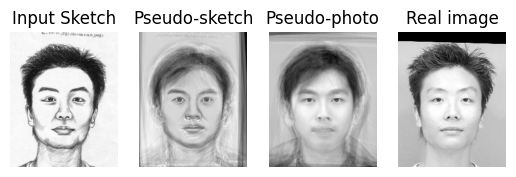

In [131]:
if ARTICLE_IMPLEMENTATION:
    plot_sk_recognition(dataset, 0, result)
else:
    data_ai.plot_sk_recognition(0, result)

## Whole Dataset runs

In [138]:
def format_top(top: np.ndarray) -> str:
    return f"{' | '.join([f'{x:3.0f}%' for x in top])}"

### Simple cut dataset run

In [139]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 5)
result = sketch_recognition(dataset, 0)
tops = result.top_k(10)
print(f"d1: {format_top(tops[0])}")
print(f"d2: {format_top(tops[1])}")
print(f"d3: {format_top(tops[2])}")

d1:  47% |  61% |  66% |  68% |  68% |  71% |  76% |  76% |  79% |  82%
d2:  76% |  87% |  89% |  95% |  95% |  97% | 100% | 100% | 100% | 100%
d3:  66% |  76% |  82% |  87% |  87% |  89% |  89% |  89% |  89% |  89%


### Cross validation run

In [141]:
def run_cross_validation(dataset: Dataset) -> list[Results]:
    results: list[Results] = []
    for i in tqdm(range(len(dataset.photo_trains)), desc="Cross-validation sets"):
        results.append(sketch_recognition(dataset, i))
    return results

#### 80/20

In [142]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 5)
TOP_K = 10
results = run_cross_validation(dataset)
top_k1, top_k2, top_k3 = np.zeros(TOP_K), np.zeros(TOP_K), np.zeros(TOP_K)
for i, result in enumerate(results):
    top_k1_loc, top_k2_loc, top_k3_loc = result.top_k(TOP_K)
    top_k1 += top_k1_loc
    top_k2 += top_k2_loc
    top_k3 += top_k3_loc
top_k1 /= len(results)
top_k2 /= len(results)
top_k3 /= len(results)

print("General Statistics")
print(f"Top {TOP_K} for d1 : {format_top(top_k1)}")
print(f"Top {TOP_K} for d2 : {format_top(top_k2)}")
print(f"Top {TOP_K} for d3 : {format_top(top_k3)}")

Cross-validation sets: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

General Statistics
Top 10 for d1 :  50% |  64% |  66% |  69% |  71% |  72% |  76% |  76% |  78% |  79%
Top 10 for d2 :  75% |  85% |  90% |  91% |  92% |  94% |  95% |  95% |  96% |  98%
Top 10 for d3 :  63% |  76% |  80% |  85% |  87% |  89% |  90% |  90% |  90% |  91%


#### 50/50

In [143]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 2)
TOP_K = 10
results = run_cross_validation(dataset)
top_k1, top_k2, top_k3 = np.zeros(TOP_K), np.zeros(TOP_K), np.zeros(TOP_K)
for i, result in enumerate(results):
    top_k1_loc, top_k2_loc, top_k3_loc = result.top_k(TOP_K)
    top_k1 += top_k1_loc
    top_k2 += top_k2_loc
    top_k3 += top_k3_loc
top_k1 /= len(results)
top_k2 /= len(results)
top_k3 /= len(results)

print("General Statistics")
print(f"Top {TOP_K} for d1 : {format_top(top_k1)}")
print(f"Top {TOP_K} for d2 : {format_top(top_k2)}")
print(f"Top {TOP_K} for d3 : {format_top(top_k3)}")

Cross-validation sets: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]

General Statistics
Top 10 for d1 :  36% |  44% |  52% |  57% |  58% |  61% |  64% |  64% |  68% |  68%
Top 10 for d2 :  62% |  68% |  72% |  75% |  76% |  78% |  82% |  84% |  84% |  86%
Top 10 for d3 :  54% |  60% |  66% |  70% |  72% |  74% |  74% |  76% |  78% |  80%


### Eigenface comparison

In [145]:
dataset = Dataset(PHOTO_PATH, SKETCH_PATH, 2)
results_eig = sketch_recognition(dataset, 0, run_mode=RunMode.EIG)
print(f"Eigenfaces: {format_top(results_eig.top_k(10)[0])}")

Eigenfaces:  59% |  65% |  72% |  76% |  79% |  80% |  82% |  82% |  82% |  82%
